<b> Spreading the Word of QAOA

In [96]:
import networkx as nx
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
import numpy as np
import matplotlib.pyplot as plt

So after the lecture you are very excited about the new technique of QAOA and want all your peers to know about it too! But because you went to the Qiskit Hackathon your network is very large by now and telling every single one of your peers about QAOA would be very time consuming which could be better spend on learning more Qiskit or watching cat videos. Therefore you create a Graph of your Network. 

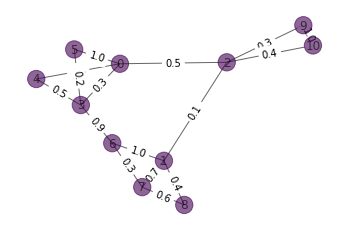

In [113]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
G.add_weighted_edges_from([(1, 2, 0.1), (2, 0, 0.5), (0, 3, 0.3), (0, 4, 0.4), (0, 5, 1.0), (3, 5, 0.2), (3, 4, 0.5), (1, 6, 1.0), (1, 7, 0.7), (1, 8, 0.4), (6, 7, 0.3), (7, 8, 0.6), (2, 9, 0.1), (2, 10, 0.4), (9, 10, 1.0), (3, 6, 0.9), (2, 9, 0.3)])
colors = [0,0,0,0,0,0,0,0,0,0,0]
def draw_graph(G,colors):
    default_axes = plt.axes(frameon=False)
    pos=nx.spring_layout(G, seed= 5)
    nx.draw_networkx(G, node_size=300, alpha=0.6, ax=default_axes, pos=pos, node_color=colors)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    


draw_graph(G,colors)

In the Graph every Node corresponds to one of your peers and the edges indicate the connection between them. The weigths on each edge is the probability that the peer will be equally excited about QAOA and spread the word.
<b> Whom of your peers should you tell about QAOA to have the best chance to reach your whole network? Use QAOA to find the optimal solution!

Just like in the lecture we start by creating the quantum circuit for QAOA.

In [98]:
def create_qaoa_circuit(G,theta):
    p = len(theta)//2
    gamma = theta[p:]
    beta = theta[:p]
    ##your code goes here
    qaoa_circuit = QuantumCircuit(len(G.nodes()))
    for i in range(qaoa_circuit.num_qubits):
        qaoa_circuit.h(i)
    
    for i in range(p):
        for edge in list(G.edges()):
            qaoa_circuit.rzz(2*gamma[i],edge[0],edge[1])
        for j in range(qaoa_circuit.num_qubits):
            qaoa_circuit.rx(2*beta[i],j)
    qaoa_circuit.measure_all()
    ##
    
    return qaoa_circuit       #qaoa_circuit should be of type QuantumCircuit 

A simple max cut will not suffice this time because not everyone of your peers will spread the word of QAOA equally likely. You can get the weights of the edges into a matrix: 

In [99]:
def get_weights(graph):
    w = np.zeros([len(graph.nodes()), len(graph.nodes())])
    for i in range(len(graph.nodes())):
        for j in range(len(graph.nodes())):
            x = graph.get_edge_data(i, j, default = 0)
            if x != 0:
                w[i, j] = x["weight"]
    return w

w

array([[0. , 0. , 0.5, 0.3, 0.4, 1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0. , 1. , 0.7, 0.4, 0. , 0. ],
       [0.5, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.4],
       [0.3, 0. , 0. , 0. , 0.5, 0.2, 0.9, 0. , 0. , 0. , 0. ],
       [0.4, 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0.9, 0. , 0. , 0. , 0.3, 0. , 0. , 0. ],
       [0. , 0.7, 0. , 0. , 0. , 0. , 0.3, 0. , 0.6, 0. , 0. ],
       [0. , 0.4, 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ]])

How does the cost function look like now that we have added weights?

In [100]:
def get_cost(graph, state):
    ##your code goes here
    cost = 0
    weights = get_weights(graph)
    for i,j in graph.edges():
        if state[i] != state[j]:
            cost -= 1*weights[i, j]
    ##
    return cost

Compute the expectation value!

In [101]:
def expectation_value(graph, counts):
    ## your code goes here
    avg = 0
    sum_count = 0
    for state, count in counts.items():
        cost = get_cost(graph, state)
        avg += cost*count
        sum_count += count
    ##    
    return avg/sum_count

We put it all together and run the classical optimization

In [102]:
def run_qpu(graph, shots=512):
    backend = Aer.get_backend('aer_simulator')
    backend.shots = shots
    
    def run_circuit(theta):
        qc = create_qaoa_circuit(graph, theta)
        counts = backend.run(qc, seed_simulator = 5, nshots= shots).result().get_counts()
        return expectation_value(graph,counts)
    
    return run_circuit

In [129]:
from scipy.optimize import minimize

p=1
theta = [1.0 for i in range(2*p)]
exp_value = run_qpu(G)

res = minimize(exp_value, theta , method = 'COBYLA')

Analyze your results. Did you find an optimal solution? What can you do to increase the accuracy?

The optimal Bitstring is 00110111110 with probabilty 0.01953125


Text(0, 0.5, 'Probabilities')

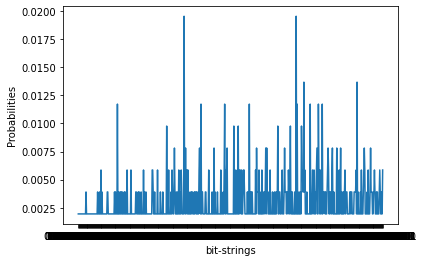

In [131]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circuit(G, res.x)

counts = backend.run(qc_res, seed_simulator = 5).result().get_counts()

strings = list(counts.keys())
probs = list(counts.values())

max_prob = max(probs)
max_string = strings[probs.index(max_prob)]
print('The optimal Bitstring is {} with probabilty {}'.format(max_string, max_prob/512) )

rescale = [i/512 for i in probs]
plt.plot(strings,rescale)
plt.xlabel('bit-strings')
plt.ylabel('Probabilities')


When looking again at the graph of your peer network, we can color the different subsets. Check the solution that you found! Does it seem plausible?

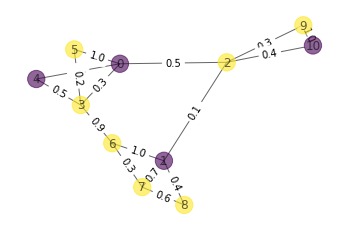

In [132]:
colors = [int(max_string[i]) for i in range(len(max_string))]
draw_graph(G,colors)